# 리뷰 분류 모델

## 모듈 호출

In [5]:
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers

#텐서플로우 eager mode false
import tensorflow as tf
#tf.config.run_functions_eagerly(False)

#하드웨어 가속기 설정
#from tensorflow.python.compiler.mlcompute import mlcompute

# Select CPU device.
#mlcompute.set_mlc_device(device_name='any')

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [6]:
pip install micompute

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement micompute
ERROR: No matching distribution found for micompute


## train, test 데이터 호출

In [7]:
df_train = pd.read_csv('data/multi_train_eomi_f.csv',encoding = 'utf-8')
df_test = pd.read_csv('data/multi_test_eomi_f.csv',encoding = 'utf-8')

## texts와 라벨을 분리

In [8]:
texts = df_train['x_train'].tolist()

In [9]:
labels = df_train['y_train'].tolist()

## 객체 생성

In [10]:
max_words = 10000                                   # 데이터셋에서 가장 빈도 높은 10,000 개의 단어만 사용한다
maxlen = 200                                        # 200개 이후의 단어는 버린다: 평균 리뷰의 길이 = 64
class_number = 6                                  # 분류할 클래스의 수(안전, 가격만족도, 재방문/지인추천, 서비스,시설/편의, 위생/청결)

tokenizer = Tokenizer(num_words=max_words)  	      # 상위빈도 10,000 개의 단어만을 추려내는 Tokenizer 객체 생성
tokenizer.fit_on_texts(texts)                       # 단어 인덱스를 구축한다
word_index = tokenizer.word_index               	  # 단어 인덱스만 가져온다

In [11]:
# 전체 데이터가 가지고 있는 토큰의 수를 보여준다. 
print('전체에서 %s개의 고유한 토큰을 찾았습니다.' % len(word_index))
print('word_index type: ', type(word_index))



전체에서 17950개의 고유한 토큰을 찾았습니다.
word_index type:  <class 'dict'>


## Data Sequencing

In [12]:
# train 데이터를 Sequencing 한다
# 상위 빈도 10,000개의 단어를 word_index의 숫자 리스트로 변환. Tokenizer 결과가 여기서 반영된다
data = tokenizer.texts_to_sequences(texts) 

# maxlen의 수만큼으로 2D 텐서를 만든다. 패딩
data = pad_sequences(data, maxlen=maxlen)

print('data:', data)

data: [[   0    0    0 ...  540 1188  109]
 [   0    0    0 ...   33   18  208]
 [   0    0    0 ...  108   16    6]
 ...
 [   0    0    0 ...   21   14    7]
 [   0    0    0 ...    5  849   53]
 [   0    0    0 ...  301  124    7]]


In [13]:
print(len(labels),data.shape)

59649 (59649, 200)


## One-Hot Encoding 함수 - 출력층에 적용

In [14]:
# 원-핫 인코딩 함수
def to_one_hot(labels, dimension):
    
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1
    return results

# 출력층만 원-핫 인코딩을 수행한다 
labels = to_one_hot(labels, dimension=class_number)

In [15]:
# 출력층의 형태
print(labels)

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


## Train data와 Validation data 준비

In [16]:
print('데이터 텐서의 크기:', data.shape)        	
print('레이블 텐서의 크기:', labels.shape)      	

indices = np.arange(data.shape[0])      		  # 0 ~ 89 까지의 숫자를 생성
np.random.shuffle(indices)                        # 0 ~ 89 까지의 숫자를 랜덤하게 섞음
data = data[indices]                              # 이것을 인덱스로 하여 2D 텐서 데이터를 섞음
labels = labels[indices]                          # label도 같은 순서로 섞음

validation_ratio = math.floor(len(texts) * 0.3)   # 30%는 검증데이터로 사용한다. 나머지는 훈련데이터
x_train = data[validation_ratio:]                 # 훈련데이터의 70%를 훈련데이터
y_train = labels[validation_ratio:]               # 훈련데이터의 70%를 훈련데이터 Label
x_val = data[:validation_ratio]                   # 훈련데이터의 30%를 검증데이터
y_val = labels[:validation_ratio]                 # 훈련데이터의 30%를 검증데이터 Label

데이터 텐서의 크기: (59649, 200)
레이블 텐서의 크기: (59649, 6)


## 모델 정의 
### 워드 임베딩 + LSTM

In [17]:
embedding_dim = 100                          # 임베딩의 차원을 설정
model = models.Sequential()                 # 모델 정의

# 임베딩 층. 나중에 임베딩된 입력을 Flatten 층에서 펼치기 위해 input_length(=maxlen)를 지정. 출력층은 (input_dim, input_length, output_dim)가 됨
model.add(layers.Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen))

# 순환층
model.add(layers.LSTM(42)) # 최종 은닉층을 32로 하였으므로 output을 32~50 사이로 하였다  

# 일반 은닉층
model.add(layers.Dense(units=32, activation='relu'))

# 출력층. 출력 노드는 분류 개수인 6. 활성화 함수는 다중분류에 사용되는 함수인 softmax 함수를 사용한다. 확률값을 출력
model.add(layers.Dense(units=class_number, activation='softmax'))

### 모델 요약 출력

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 42)                24024     
_________________________________________________________________
dense (Dense)                (None, 32)                1376      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 1,025,598
Trainable params: 1,025,598
Non-trainable params: 0
_________________________________________________________________


## Compile Model

In [19]:
# 가중치 업데이트는 이동평균 방법인 RMSprop을 사용하였다.
# 신경망의 출력이 확률이므로 crossentropy를 사용하는 것이 최선이다
# crossentropy는 원본의 확률 분포와 예측의 확률 분포를 측정하여 조절해 간다
# 또한 다중 분류이므로 categorical_crossentropy를 사용한다

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

## Train Model

In [20]:
# 훈련데이터로 훈련하고, 검증데이터로 검증한다
# 반환값의 history는 훈련하는 동안 발생한 모든 정보를 담고 있는 딕셔너리이다

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

history_dict = history.history

Epoch 1/10
1305/1305 [==============================] - 119s 89ms/step - loss: 0.6077 - acc: 0.7912 - val_loss: 0.3257 - val_acc: 0.9067
Epoch 2/10
1305/1305 [==============================] - 117s 90ms/step - loss: 0.1941 - acc: 0.9429 - val_loss: 0.1739 - val_acc: 0.9459
Epoch 3/10
1305/1305 [==============================] - 117s 90ms/step - loss: 0.1150 - acc: 0.9660 - val_loss: 0.1406 - val_acc: 0.9580
Epoch 4/10
1305/1305 [==============================] - 117s 90ms/step - loss: 0.0781 - acc: 0.9759 - val_loss: 0.1381 - val_acc: 0.9581
Epoch 5/10
1305/1305 [==============================] - 117s 90ms/step - loss: 0.0535 - acc: 0.9839 - val_loss: 0.1359 - val_acc: 0.9621
Epoch 6/10
1305/1305 [==============================] - 123s 94ms/step - loss: 0.0380 - acc: 0.9889 - val_loss: 0.1085 - val_acc: 0.9700
Epoch 7/10
1305/1305 [==============================] - 123s 95ms/step - loss: 0.0275 - acc: 0.9919 - val_loss: 0.1178 - val_acc: 0.9659
Epoch 8/10
1305/1305 [===================

## Accuracy and Loss 확인

In [21]:
# history 딕셔너리 안에 있는 정확도와 손실값을 가져와 본다
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

print('Accuracy of each epoch:', acc)
epochs = range(1, len(acc) +1)

Accuracy of each epoch: [0.7912346124649048, 0.9429289698600769, 0.965968132019043, 0.9758591651916504, 0.9838582277297974, 0.988911509513855, 0.9919291138648987, 0.9940366148948669, 0.9956651926040649, 0.997006356716156]


## Plotting Accuracy
- 정확도와 손실값의 변화를 보고, epoch를 어디에서 조절해야 할 지를 가늠한다.
- 정확도가 떨어지는 구간, 손실값이 높게 나타나는 구간을 확인한다
- 데이터가 큰 경우 대개 epoch를 늘려야 최적값에 도달한다

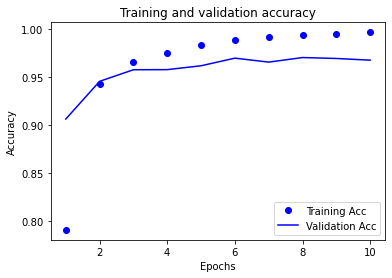

In [22]:
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()     

## Plotting Loss

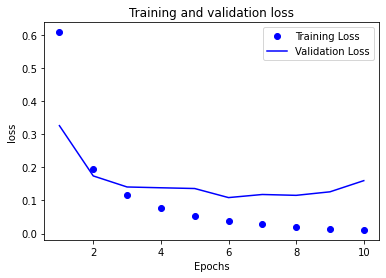

In [23]:
plt.figure()            	

# 손실값 
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()            		

plt.show()

## 모델 및 토크나이저 저장 

In [24]:
# multidimensional numpy arrays를 저장할 수 있는 h5 file(HDF) 포맷으로 저장한다
model.save('data/text_multi_model.h5') 	     # 모델 저장

# 훈련데이터에서 사용된 상위빈도 10,000개의 단어로 된 Tokenizer 저장
# 새로 입력되는 문장에서도 같은 단어가 추출되게 한다
import pickle
with open('data/text_multi_tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Load Model

In [25]:
import os
from tensorflow.keras.models import load_model

loaded_model = load_model('data/text_multi_model.h5')
print("model loaded:", loaded_model)

with open('data/text_multi_tokenizer.pickle', 'rb') as handle:
       loaded_tokenizer = pickle.load(handle)

model loaded: <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000015A4DC7C0A0>


## 테스트 세트로 검증
- 모든 리뷰의 형태소를 통해 선정한 키워드 기준으로 라벨링 하였기 때문에 사전에 정의된 단어를 포함하는 리뷰에 대해서는 높은 예측을 하는 것을 확인
- 사전에 없는 단어가 있을 경우 예측 불가

In [26]:
x_test = df_test['x_test']
y_test = df_test['y_test']


In [27]:
test_texts = df_test['x_test'].tolist()
test_labels = df_test['y_test'].tolist()

## 저장한 모델 호출
### 로딩된 tokenizer로 test 데이터를 Sequencing 한다

In [28]:
test_data = loaded_tokenizer.texts_to_sequences(test_texts) 	# 문자열을 숫자 리스트로 변환
x_test = pad_sequences(test_data, maxlen=maxlen)     	    # maxlen의 수만큼으로 2D 텐서를 만듦
print('data:', test_data)

# label에 해당하는 부분만 one-hot-encoding 한다.
y_test = to_one_hot(test_labels, dimension=class_number)

data: [[159, 20, 5, 48, 140, 2, 92, 61, 17, 18, 55, 7, 230, 179, 92, 248, 189, 18, 1452, 75, 11, 10, 73, 26, 25, 672, 124], [254, 11, 81, 36, 7, 7242, 12, 3459, 15, 24, 14, 5, 246, 79, 198, 249, 2475, 275, 259, 211, 1714, 211, 25, 871, 29, 157, 166, 4982, 1413, 1190, 451, 12, 24, 919, 104, 663, 88, 254, 30, 1992, 967, 414, 2, 1033, 345, 10, 15, 1, 25, 258, 3, 53], [29, 21], [955, 81, 80, 144, 14, 93, 326, 228, 80, 50, 246, 591, 759, 230, 15, 172, 3, 739, 16, 4, 859, 36, 840, 146, 740, 3, 302, 78, 577, 200, 983, 759, 530, 759, 528, 470, 15], [24, 130, 5, 23, 275, 1, 135, 84, 124, 84, 199, 50, 40, 43, 446, 6, 226, 40, 530, 245, 478, 235, 60, 131, 376, 1481, 376, 110, 435, 246, 16, 662, 872, 2154, 59, 256, 631, 16], [1, 482, 289, 11, 3, 1, 24, 130, 5, 719, 23, 48, 1239, 30, 1, 15, 2688, 97, 3481, 3533, 295, 119, 2409, 1, 804, 69, 4, 48, 30, 119, 2354, 97, 1088, 4, 3494, 2, 207], [79, 334, 220, 145, 234, 1, 404, 277, 2017, 1276, 1528, 74, 200, 4, 1119, 67, 405, 42, 183, 22, 214, 2, 19, 91,

## Test Data Evaluation

In [29]:
test_eval = loaded_model.evaluate(x_test, y_test)
print('prediction model loss & acc:', test_eval)

799/799 [==============================] - 19s 24ms/step - loss: 0.1570 - acc: 0.9679
prediction model loss & acc: [0.1570201814174652, 0.9679248929023743]


In [30]:
predictions = loaded_model.predict(x_test)
print('predictions shape:', predictions.shape)
print('prediction 0 shape:', predictions[0].shape)
print('prediction 0 sum', np.sum(predictions[0]))             # 모든 분류에 대한 확률의 총합은 1이 되어야 한다

print('prediction 0 value:', predictions[0])                  # 6개 분류 각각에 대한 확률값
print('prediction 0 max value:', np.argmax(predictions[0]))  	# prediction 0이 가지고 있는 가장 큰 값의 판정 결과
print('prediction 1 max value:', np.argmax(predictions[1]))   # prediction 1이 가지고 있는 가장 큰 값의 판정 결과
print('prediction 2 max value:', np.argmax(predictions[2]))   # prediction 2가 가지고 있는 가장 큰 값의 판정 결과

predictions shape: (25565, 6)
prediction 0 shape: (6,)
prediction 0 sum 0.99999994
prediction 0 value: [2.5792103e-08 8.8275812e-07 9.9998903e-01 2.7069619e-08 1.0021183e-05
 1.3822327e-08]
prediction 0 max value: 2
prediction 1 max value: 3
prediction 2 max value: 4


## 새로운 입력값으로 평가
- 키워드 사전: 안전:0, 가격만족도:1, 재방문/지인추천:2, 서비스:3, 시설/편의:4, 위생/청결:5
- 키워드는 형태소 분리된 형태로 입력되어야 함(작업환경에서 rhinoMorph 형태소 분석기가 충돌을 일으켜 외부에서 분리한 형태소 분석된 텍스트를 사용)

In [41]:
input_text = ['휴게 시설 편리 너무 좋']
input_data = loaded_tokenizer.texts_to_sequences(input_text)
input_x = pad_sequences(input_data, maxlen=maxlen)

predictions = loaded_model.predict(input_x)
print("Result:", predictions) # 각 분류에 대한 확률을 보여준다
print("분류 결과: ", np.argmax(predictions[0])) # 가장 큰 확률값을 가진 분류 제시. 0~5 숫자 중 하나

Result: [[4.0587986e-14 3.7957389e-12 2.1065089e-10 3.7470822e-09 1.0000000e+00
  9.4469354e-13]]
분류 결과:  4


#### 문제점

- 사전에 등록된 텍스트가 아닐 경우 예측 할 수 없음     
: 사전에 등록된 데이터로 라벨링을 하였기 때문에 발생하는 것이라고 판단
 
- 사전에 등록된 키워드의 경우 완벽하게 예측(과적합이라고 예상)
- 여러가지 의미가 담긴 경우 가중치에 따라 한가지 리뷰로 분리 할 수 밖에 없음
- 댓글에 포함된 키워드가 어디에 속하는지 분류 하는 모델 정도이기에 사전을 통해 정통적인 알고리즘으로도 해결 할 수 있을 것이라고 판단

### 해결방안 및 이용방안
- 사전에 있는 키워드를 이용하기 때문에 사전 튜닝이 중요해 보임
- 사전에 없는 키워드가 입력될 경우 출력층의 One hot encoding의 확률이 일정 이상일 경우 리뷰를 분류하도록 코딩 필요
- 토큰화된 리뷰의 키워드가 사전에 정해진 키워드에 없을 경우 리뷰를 걸러내는 코드와 함께 사용해야 한다